# MIFOCAT K-Fold Cross-Validation Training Notebook
## Cardiac Myocardium Segmentation with TensorFlow/Keras

This notebook orchestrates end-to-end k-fold cross-validation training for cardiac segmentation using the MIFOCAT loss function.

**Key Steps:**
1. Setup and imports
2. Load and split dataset with patient-level stratification
3. Initialize data loaders and trainer
4. Train all k folds with early stopping and checkpointing
5. Aggregate and visualize fold results

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add project to path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

Project root: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation
Python version: 3.11.14 (main, Oct 21 2025, 18:27:30) [Clang 20.1.8 ]
NumPy version: 1.26.4


In [2]:
try:
    import tensorflow as tf
    from tensorflow import keras
    print(f"TensorFlow version: {tf.__version__}")
    
    # Check for Apple Silicon GPU availability
    if tf.config.list_physical_devices('GPU'):
        print(f"✓ GPU detected: {tf.config.list_physical_devices('GPU')}")
    else:
        print(" No GPU detected. Using CPU.")
        print(f"  Available devices: {tf.config.list_physical_devices()}")
    
except ImportError as e:
    print(f"TensorFlow import failed: {e}")
    print("Install with: pip install tensorflow keras")

try:
    from split_data import CardiacDataSplitter
    from custom_datagen import FoldAwareDataLoader
    from train_kfold_wrapper import KFoldTrainer
    print("✓ Custom modules imported successfully")
except ImportError as e:
    print(f"Custom module import failed: {e}")
    print("Ensure split_data.py, custom_datagen.py, and train_kfold_wrapper.py are in the project root.")

TensorFlow version: 2.15.0
✓ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Custom modules imported successfully


## Configuration
Set up paths, hyperparameters, and k-fold settings.

In [3]:
# ============ CONFIGURATION ============

# Data paths - ACDC2017 Dataset Structure
DATA_ROOT = Path.cwd() / "acdc2017" / "Data 2D" / "ED" / "Data Per Pasien Training 2D"
OUTPUT_DIR = Path.cwd() / "kfold_results"
OUTPUT_DIR.mkdir(exist_ok=True)

# K-Fold parameters
N_SPLITS = 5                    # Number of folds
VAL_RATIO = 0.1               # Validation ratio per fold
RANDOM_SEED = 42

# Training parameters
MODEL_TYPE = "unet"            # Options: "unet", "transunet", "resnet", etc.
EPOCHS_PER_FOLD = 50
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 10
IMAGE_SUBDIR = "images"        # Subdirectory for images within patient folders
MASK_SUBDIR = "groundtruth"    # Subdirectory for masks within patient folders (ACDC2017 uses 'groundtruth')

# Model checkpoint output
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True)

# Print configuration
print("=" * 50)
print("K-FOLD TRAINING CONFIGURATION")
print("=" * 50)
print(f"Data root: {DATA_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Number of folds: {N_SPLITS}")
print(f"Validation ratio: {VAL_RATIO}")
print(f"Model type: {MODEL_TYPE}")
print(f"Epochs per fold: {EPOCHS_PER_FOLD}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"Mask subdirectory: {MASK_SUBDIR}")
print("=" * 50)

K-FOLD TRAINING CONFIGURATION
Data root: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
Output directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results
Number of folds: 5
Validation ratio: 0.1
Model type: unet
Epochs per fold: 50
Batch size: 32
Early stopping patience: 10
Mask subdirectory: groundtruth


## Step 1: Load and Split Dataset
Use `CardiacDataSplitter` to generate patient-level stratified k-fold splits and create metadata.

In [4]:
# Initialize the data splitter
# splitter = CardiacDataSplitter(
#     input_folder=str(DATA_ROOT),
#     output_folder=str(OUTPUT_DIR)
# )

# Run k-fold split
# This generates kfold_metadata.json with patient-to-fold assignments
# print(f"\nExecuting k-fold split with n_splits={N_SPLITS}, val_ratio={VAL_RATIO}...")
# print(f"Data directory: {DATA_ROOT}")
# print(f"Data directory exists: {DATA_ROOT.exists()}")

# splitter.kfold_split(
#     n_splits=N_SPLITS,
#     val_ratio=VAL_RATIO
# )
# print("✓ K-fold split complete")

# Load the metadata to inspect fold structure
metadata_path = OUTPUT_DIR / "kfold_metadata.json"
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\nK-Fold Metadata Summary:")
print(f"  Total patients: {metadata['total_patients']}")
print(f"  Total folds: {metadata['n_splits']}")
for fold_data in metadata['folds']:
    fold_id = fold_data.get('fold_id', '?')
    train_patients = len(fold_data.get('train', []))
    val_patients = len(fold_data.get('val', []))
    print(f"  Fold {fold_id}: {train_patients} train, {val_patients} val patients")


K-Fold Metadata Summary:
  Total patients: 99
  Total folds: 5
  Fold 0: 72 train, 20 val patients
  Fold 1: 72 train, 20 val patients
  Fold 2: 72 train, 20 val patients
  Fold 3: 72 train, 20 val patients
  Fold 4: 72 train, 19 val patients


## Step 2: Initialize Data Loader and Trainer
Set up the fold-aware data loader and k-fold trainer.

In [5]:
# Initialize the k-fold trainer
# NOTE: KFoldTrainer.get_model() is a placeholder; you must implement it with your model architecture
trainer = KFoldTrainer(
    base_data_dir=str(DATA_ROOT),
    fold_metadata_path=str(metadata_path),
    output_dir=str(OUTPUT_DIR)
)

print("✓ KFoldTrainer initialized")
print(f"  Metadata: {metadata_path}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Checkpoint directory: {CHECKPOINT_DIR}")

[KFoldTrainer] Loaded metadata for 5-fold CV
[KFoldTrainer] Output directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results
[KFoldTrainer] Initializing data loader...
[KFoldTrainer] Base data directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[KFoldTrainer] Base data directory exists: True
✓ KFoldTrainer initialized
  Metadata: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/kfold_metadata.json
  Output directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results
  Checkpoint directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/checkpoints


## Step 3: Train All K-Folds
Run training for each fold with early stopping and checkpointing. This may take a long time.

**Note:** Before running training, ensure you have implemented the `get_model()` method in `train_kfold_wrapper.py` to instantiate and compile your model with the MIFOCAT loss function.

In [6]:
# DIAGNOSTIC: Test data loading before training
import sys
sys.stdout.flush()

print("=" * 70)
print("DIAGNOSTIC: Testing Data Loader")
print("=" * 70)

# Force import reload to get latest debugging code
import importlib
import custom_datagen
importlib.reload(custom_datagen)
from custom_datagen import FoldAwareDataLoader

# Test creating a loader with the same parameters
test_loader = FoldAwareDataLoader(
    str(DATA_ROOT),
    str(metadata_path)
)

print("\n✓ Test loader created successfully")
print(f"Base directory: {test_loader.base_dir}")
print(f"Base directory exists: {test_loader.base_dir.exists()}")

# Try to get generators for fold 0
print("\n" + "-" * 70)
print("Testing fold 0 generator creation...")
print("-" * 70)
sys.stdout.flush()

try:
    test_train_gen, test_val_gen, test_train_steps, test_val_steps = test_loader.get_generators(
        fold_id=0,
        batch_size=BATCH_SIZE
    )
    print(f"\n✓✓✓ SUCCESS! Data loading works!")
    print(f"    Training steps: {test_train_steps}")
    print(f"    Validation steps: {test_val_steps}")
    print(f"\nIf you see this, the data can be loaded. Proceed with training.")
except Exception as e:
    print(f"\n✗✗✗ FAILED! Error: {e}")
    import traceback
    traceback.print_exc()
    print("\nPlease fix the error above before running training.")

sys.stdout.flush()
print("=" * 70)

DIAGNOSTIC: Testing Data Loader

✓ Test loader created successfully
Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
Base directory exists: True

----------------------------------------------------------------------
Testing fold 0 generator creation...
----------------------------------------------------------------------

[FoldAwareDataLoader.get_generators] ===== STARTING FOLD 0 =====
[FoldAwareDataLoader.get_generators] Image subdir: images, Mask subdir: groundtruth
[FoldAwareDataLoader.get_generators] Target size: (256, 256)
[FoldAwareDataLoader.get_generators] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader] Fold 0: 72 train patients, 20 val patients
[FoldAwareDataLoader] Train patients: ['1', '10', '11', '12', '13']...
[FoldAwareDataLoader] Val patients: ['16', '17', '2', '27', '29']...
[FoldAwareDataLoader.get_file_lis

In [7]:
import time

# Run all folds
start_time = time.time()

print("\n" + "=" * 70)
print("STARTING K-FOLD CROSS-VALIDATION TRAINING")
print("=" * 70)

try:
    trainer.run_all_folds(
        model_type=MODEL_TYPE,
        epochs=EPOCHS_PER_FOLD,
        batch_size=BATCH_SIZE,
        train_only=False,  # Set to False if you want evaluation per fold
        start_fold=1      # Resume from fold 1 (fold 0 already done)
    )
    print("\n✓ Training completed successfully!")
except Exception as e:
    print(f"\n✗ Training failed with error: {e}")
    import traceback
    traceback.print_exc()

elapsed_time = time.time() - start_time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"\nTotal training time: {hours}h {minutes}m {seconds}s")


STARTING K-FOLD CROSS-VALIDATION TRAINING

######################################################################
# K-FOLD CROSS-VALIDATION: 5 Folds
# Metadata: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/kfold_metadata.json
# Data dir: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
# Output dir: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results
# Starting from fold: 1
# Started: 2026-01-26 17:32:05
######################################################################

[FOLD 0] Skipping (already completed / start_fold=1)
[KFoldTrainer] Loading U-Net model with MIFOCAT loss...


2026-01-26 17:32:05.782172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2026-01-26 17:32:05.782206: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2026-01-26 17:32:05.782210: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2026-01-26 17:32:05.782455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-26 17:32:05.782903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[KFoldTrainer] Model compiled with MIFOCAT loss

[FOLD 1] Starting training
[FOLD 1] Loading data generators...

[FoldAwareDataLoader.get_generators] ===== STARTING FOLD 1 =====
[FoldAwareDataLoader.get_generators] Image subdir: images, Mask subdir: groundtruth
[FoldAwareDataLoader.get_generators] Target size: (256, 256)
[FoldAwareDataLoader.get_generators] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader] Fold 1: 72 train patients, 20 val patients
[FoldAwareDataLoader] Train patients: ['1', '10', '11', '12', '14']...
[FoldAwareDataLoader] Val patients: ['13', '19', '24', '30', '32']...
[FoldAwareDataLoader.get_file_list] Starting file list collection
[FoldAwareDataLoader.get_file_list] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader.get_file_list] Base directory exists: True
[FoldAwareDataLoader.get_file_

2026-01-26 17:32:07.980904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2026-01-26 17:32:08.198508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


21/21 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.9195 - mean_iou: 0.7640 - dice_score: 0.8201
Epoch 1: val_loss improved from inf to 5.66605, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_1/fold_1_best_model.h5


/Users/iganarendra/miniconda3/envs/tf_metal/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 67s 3s/step - loss: 0.5727 - accuracy: 0.9195 - mean_iou: 0.7640 - dice_score: 0.8201 - val_loss: 5.6661 - val_accuracy: 0.2836 - val_mean_iou: 0.1572 - val_dice_score: 0.2717
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9999 - mean_iou: 0.9562 - dice_score: 0.9776
Epoch 2: val_loss did not improve from 5.66605
21/21 [==============================] - 62s 3s/step - loss: 0.1441 - accuracy: 0.9999 - mean_iou: 0.9562 - dice_score: 0.9776 - val_loss: 154.3584 - val_accuracy: 0.0254 - val_mean_iou: 0.0131 - val_dice_score: 0.0259
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9998 - mean_iou: 0.9563 - dice_score: 0.9777
Epoch 3: val_loss did not improve from 5.66605
21/21 [==============================] - 63s 3s/step - loss: 0.0955 - accuracy: 0.9998 - mean_iou: 0.9563 - dice_score: 0.9777 - val_loss: 207.2858 - val_accuracy: 0.0119 - val_mean_iou: 0.0061 - val_di

[KFoldTrainer] Model compiled with MIFOCAT loss

[FOLD 2] Starting training
[FOLD 2] Loading data generators...

[FoldAwareDataLoader.get_generators] ===== STARTING FOLD 2 =====
[FoldAwareDataLoader.get_generators] Image subdir: images, Mask subdir: groundtruth
[FoldAwareDataLoader.get_generators] Target size: (256, 256)
[FoldAwareDataLoader.get_generators] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader] Fold 2: 72 train patients, 20 val patients
[FoldAwareDataLoader] Train patients: ['10', '11', '13', '14', '15']...
[FoldAwareDataLoader] Val patients: ['1', '12', '18', '28', '40']...
[FoldAwareDataLoader.get_file_list] Starting file list collection
[FoldAwareDataLoader.get_file_list] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader.get_file_list] Base directory exists: True
[FoldAwareDataLoader.get_file_

2026-01-26 18:22:55.781580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


21/21 [==============================] - ETA: 0s - loss: 1.2295 - accuracy: 0.7456 - mean_iou: 0.4659 - dice_score: 0.5568
Epoch 1: val_loss improved from inf to 42016.65625, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_2/fold_2_best_model.h5
21/21 [==============================] - 64s 3s/step - loss: 1.2295 - accuracy: 0.7456 - mean_iou: 0.4659 - dice_score: 0.5568 - val_loss: 42016.6562 - val_accuracy: 0.0039 - val_mean_iou: 0.0020 - val_dice_score: 0.0040
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.9964 - mean_iou: 0.9368 - dice_score: 0.9671
Epoch 2: val_loss improved from 42016.65625 to 25.98711, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_2/fold_2_best_model.h5
21/21 [==============================] - 64s 3s/step - loss: 0.4124 - accuracy: 0.9964 - mean_iou: 0.9368 - dice_score: 0.9671 - val_loss: 25.9871 - val_accuracy: 0.1197 - val_mean_iou: 0

[KFoldTrainer] Model compiled with MIFOCAT loss

[FOLD 3] Starting training
[FOLD 3] Loading data generators...

[FoldAwareDataLoader.get_generators] ===== STARTING FOLD 3 =====
[FoldAwareDataLoader.get_generators] Image subdir: images, Mask subdir: groundtruth
[FoldAwareDataLoader.get_generators] Target size: (256, 256)
[FoldAwareDataLoader.get_generators] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader] Fold 3: 72 train patients, 20 val patients
[FoldAwareDataLoader] Train patients: ['1', '10', '12', '13', '16']...
[FoldAwareDataLoader] Val patients: ['11', '14', '15', '21', '22']...
[FoldAwareDataLoader.get_file_list] Starting file list collection
[FoldAwareDataLoader.get_file_list] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader.get_file_list] Base directory exists: True
[FoldAwareDataLoader.get_file_

2026-01-26 19:16:30.688043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.9178 - mean_iou: 0.7475 - dice_score: 0.8065
Epoch 1: val_loss improved from inf to 181.54611, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_3/fold_3_best_model.h5
22/22 [==============================] - 70s 3s/step - loss: 0.6117 - accuracy: 0.9178 - mean_iou: 0.7475 - dice_score: 0.8065 - val_loss: 181.5461 - val_accuracy: 0.0080 - val_mean_iou: 0.0041 - val_dice_score: 0.0081
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9984 - mean_iou: 0.9547 - dice_score: 0.9768
Epoch 2: val_loss did not improve from 181.54611
22/22 [==============================] - 67s 3s/step - loss: 0.1754 - accuracy: 0.9984 - mean_iou: 0.9547 - dice_score: 0.9768 - val_loss: 1647.3781 - val_accuracy: 0.0090 - val_mean_iou: 0.0046 - val_dice_score: 0.0091
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.996

[KFoldTrainer] Model compiled with MIFOCAT loss

[FOLD 4] Starting training
[FOLD 4] Loading data generators...

[FoldAwareDataLoader.get_generators] ===== STARTING FOLD 4 =====
[FoldAwareDataLoader.get_generators] Image subdir: images, Mask subdir: groundtruth
[FoldAwareDataLoader.get_generators] Target size: (256, 256)
[FoldAwareDataLoader.get_generators] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader] Fold 4: 72 train patients, 19 val patients
[FoldAwareDataLoader] Train patients: ['1', '11', '12', '13', '14']...
[FoldAwareDataLoader] Val patients: ['10', '20', '26', '31', '4']...
[FoldAwareDataLoader.get_file_list] Starting file list collection
[FoldAwareDataLoader.get_file_list] Base directory: /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/acdc2017/Data 2D/ED/Data Per Pasien Training 2D
[FoldAwareDataLoader.get_file_list] Base directory exists: True
[FoldAwareDataLoader.get_file_l

2026-01-26 20:08:51.268180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.9046 - mean_iou: 0.7624 - dice_score: 0.8172
Epoch 1: val_loss improved from inf to 3032.58423, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_4/fold_4_best_model.h5
22/22 [==============================] - 68s 3s/step - loss: 0.5956 - accuracy: 0.9046 - mean_iou: 0.7624 - dice_score: 0.8172 - val_loss: 3032.5842 - val_accuracy: 6.8390e-04 - val_mean_iou: 3.5015e-04 - val_dice_score: 7.0005e-04
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9988 - mean_iou: 0.9568 - dice_score: 0.9779
Epoch 2: val_loss improved from 3032.58423 to 351.11682, saving model to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/fold_4/fold_4_best_model.h5
22/22 [==============================] - 63s 3s/step - loss: 0.1316 - accuracy: 0.9988 - mean_iou: 0.9568 - dice_score: 0.9779 - val_loss: 351.1168 - val_accuracy: 0.1022 - val_

## Step 4: Load and Display Aggregated Results
After training completes, load the aggregated metrics across all folds.

In [11]:
# Load aggregated results
fold_results_path = OUTPUT_DIR / "fold_results.json"
aggregated_results_path = OUTPUT_DIR / "aggregated_results.json"

if fold_results_path.exists():
    with open(fold_results_path, 'r') as f:
        fold_results = json.load(f)
    print("Fold-specific results:")
    for fold_idx, metrics in enumerate(fold_results):
        if metrics:  # Skip empty folds
            print(f"\n  Fold {fold_idx}:")
            for metric_name, value in metrics.items():
                if isinstance(value, float):
                    print(f"    {metric_name}: {value:.6f}")
                elif metric_name != 'checkpoint':
                    print(f"    {metric_name}: {value}")
    
    # Display as DataFrame table
    print("\n" + "=" * 80)
    print("FOLD RESULTS SUMMARY TABLE")
    print("=" * 80)
    fold_df = pd.DataFrame(fold_results)
    # Select key columns for display
    display_cols = ['fold_id', 'final_loss', 'final_val_loss', 'best_val_loss', 'epochs_trained']
    fold_df_display = fold_df[display_cols].set_index('fold_id')
    print(fold_df_display.to_string())
    print("=" * 80)
else:
    print(f"Fold results not found at {fold_results_path}")
    fold_results = []


Fold-specific results:

  Fold 0:
    fold_id: 0
    final_loss: 0.008181
    final_val_loss: 0.014735
    best_val_loss: 0.011824
    epochs_trained: 41

  Fold 1:
    fold_id: 1
    final_loss: 0.007312
    final_val_loss: 0.008162
    best_val_loss: 0.008162
    epochs_trained: 50

  Fold 2:
    fold_id: 2
    final_loss: 0.007635
    final_val_loss: 0.010060
    best_val_loss: 0.008818
    epochs_trained: 50

  Fold 3:
    fold_id: 3
    final_loss: 0.006727
    final_val_loss: 0.016787
    best_val_loss: 0.006292
    epochs_trained: 50

  Fold 4:
    fold_id: 4
    final_loss: 0.009630
    final_val_loss: 0.013821
    best_val_loss: 0.010707
    epochs_trained: 40

FOLD RESULTS SUMMARY TABLE
         final_loss  final_val_loss  best_val_loss  epochs_trained
fold_id                                                           
0          0.008181        0.014735       0.011824              41
1          0.007312        0.008162       0.008162              50
2          0.007635       

## Step 5: Visualize Training History
Plot training and validation metrics per fold to assess convergence and overfitting.

In [17]:
N_SPLITS

5

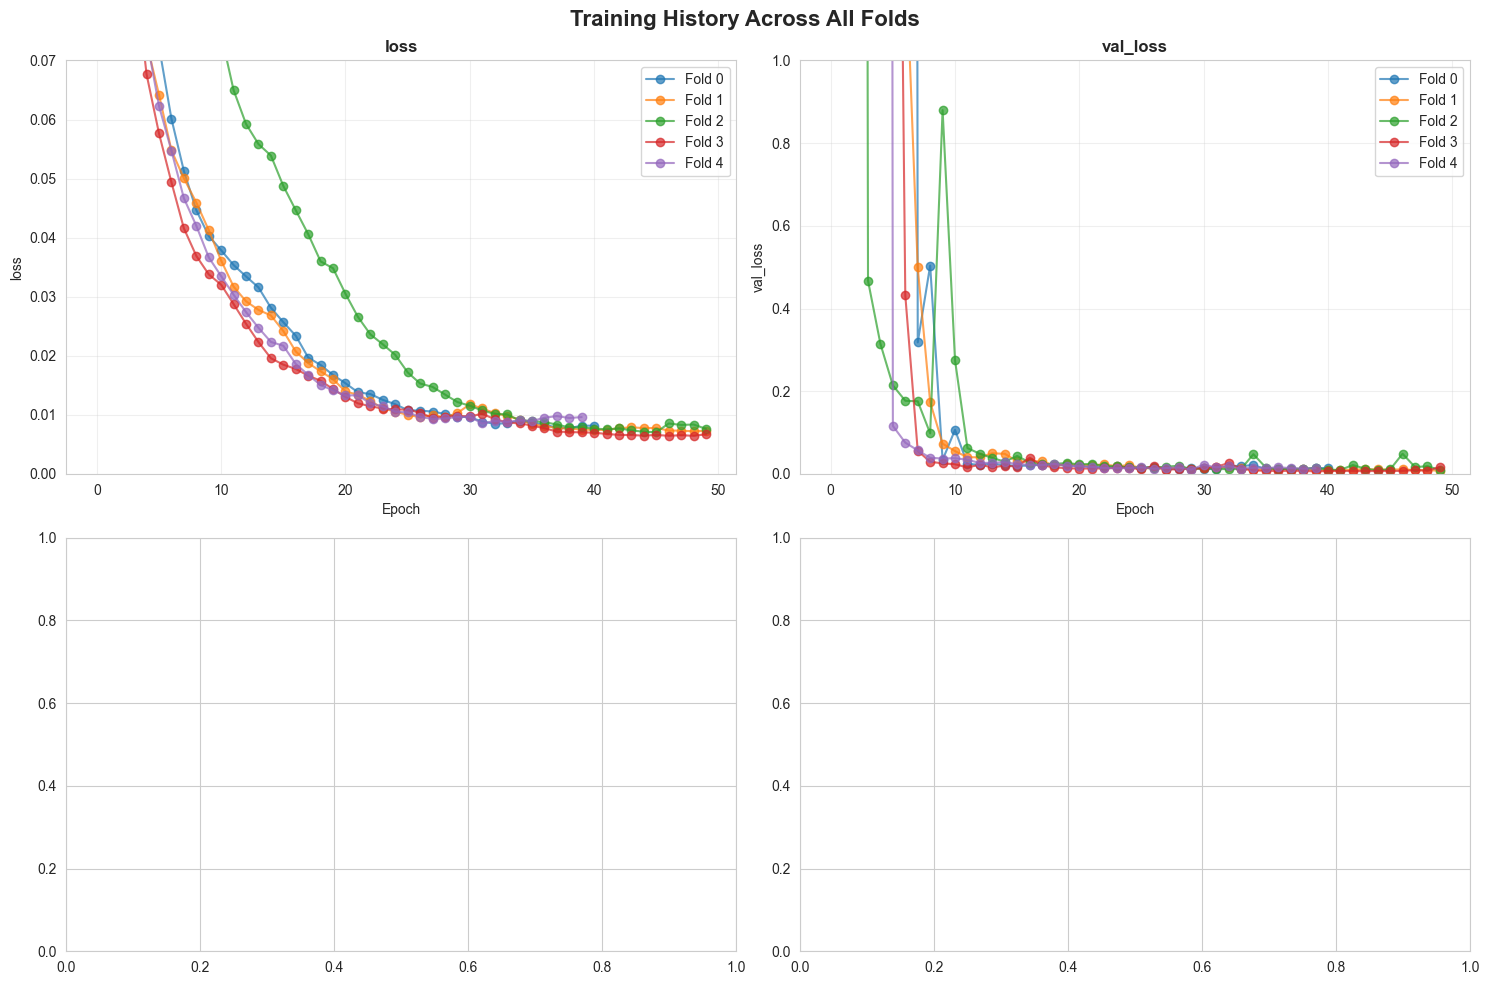

✓ Training history plot saved to /Users/iganarendra/Downloads/Code-Cardiac-Segmentation/kfold_results/training_history.png


In [20]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Collect all training histories
all_histories = {}
history_dir = OUTPUT_DIR
for fold_id in range(N_SPLITS):
    history_file = history_dir / f"fold_{fold_id}"/ f"fold_{fold_id}_history.json"
    if history_file.exists():
        with open(history_file, 'r') as f:
            all_histories[fold_id] = json.load(f)

if all_histories:
    # Plot metrics per fold
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Across All Folds', fontsize=16, fontweight='bold')
    
    # Determine available metrics (from first fold)
    first_fold_history = all_histories[0]
    metrics_to_plot = [k for k in first_fold_history.keys() if 'loss' in k or 'metric' in k][:4]
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes.flatten()[idx]
        for fold_id, history in all_histories.items():
            if metric in history:
                ax.plot(history[metric], marker='o', label=f'Fold {fold_id}', alpha=0.7)
        ax.set_title(metric, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        
        # Set Y-axis limits based on metric type
        if 'val_loss' in metric:
            ax.set_ylim(0, 1)
        elif 'loss' in metric:
            ax.set_ylim(0, 0.07)
        
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Training history plot saved to {OUTPUT_DIR / 'training_history.png'}")
else:
    print("No training history files found. Training may not have completed.")

## Step 6: Summary and Recommendations
Display final summary and provide next steps.

In [ ]:
print("\n" + "=" * 70)
print("K-FOLD CROSS-VALIDATION TRAINING SUMMARY")
print("=" * 70)

summary = f"""
✓ Training Configuration:
  - Number of folds: {N_SPLITS}
  - Model type: {MODEL_TYPE}
  - Epochs per fold: {EPOCHS_PER_FOLD}
  - Batch size: {BATCH_SIZE}
  - Early stopping patience: {EARLY_STOP_PATIENCE}

✓ Output Artifacts:
  - Checkpoints: {CHECKPOINT_DIR}
  - Results: {OUTPUT_DIR}
  - Metadata: {OUTPUT_DIR / 'kfold_metadata.json'}
  - Fold results: {OUTPUT_DIR / 'fold_results.json'}
  - Aggregated results: {OUTPUT_DIR / 'aggregated_results.json'}

✓ Next Steps:
  1. Review aggregated_results.json for final performance metrics
  2. Inspect individual fold checkpoints for the best model per fold
  3. Load best checkpoint and run inference on test set (see hitung_evaluasi_metrik.py)
  4. For publication: Include aggregated metrics (mean ± std) in results tables
  5. Optionally: Run ablation studies on MIFOCAT loss components (L_MI, L_FO, L_CAT)

✓ Reproducibility:
  - Random seed: {RANDOM_SEED}
  - K-fold metadata: kfold_metadata.json (patient-to-fold assignments)
  - Training logs: Individual fold_*_history.json files
"""

print(summary)

# Display aggregated metrics summary table if available
# if aggregated_results:
#     print("\n" + "=" * 70)
#     print("AGGREGATED METRICS SUMMARY")
#     print("=" * 70)
#     df_summary = pd.DataFrame(aggregated_results).T
#     print(df_summary.to_string())

## Appendix: Optional - Load Best Model and Run Inference
Uncomment and modify this section to load a trained model and run inference on sample data.

In [ ]:
# Example: Load best model from a fold and run inference
# Uncomment to use:

# from keras.models import load_model
# import cv2
# from pathlib import Path

# # Select the best fold (e.g., Fold 0)
# best_fold = 0
# best_model_path = CHECKPOINT_DIR / f"fold_{best_fold}_best_model.h5"

# if best_model_path.exists():
#     # Load model with custom objects if needed
#     custom_objects = {}  # Add custom layers/losses if using TransUNet or custom MIFOCAT loss
#     model = load_model(best_model_path, custom_objects=custom_objects)
#     print(f"✓ Loaded model from {best_model_path}")
    
#     # Example inference on a test image
#     test_image_path = DATA_ROOT / "Pasien_001" / "images" / "image_001.png"
#     if test_image_path.exists():
#         img = cv2.imread(str(test_image_path), cv2.IMREAD_GRAYSCALE)
#         img = cv2.resize(img, (224, 224))  # Adjust to your model input size
#         img_normalized = img.astype('float32') / 255.0
#         img_batch = np.expand_dims(np.expand_dims(img_normalized, axis=0), axis=-1)
        
#         # Run prediction
#         prediction = model.predict(img_batch, verbose=0)
#         print(f"Prediction shape: {prediction.shape}")
#         print(f"Prediction range: [{prediction.min():.4f}, {prediction.max():.4f}]")
        
#         # Visualize
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         axes[0].imshow(img, cmap='gray')
#         axes[0].set_title('Input Image')
#         axes[0].axis('off')
        
#         axes[1].imshow(prediction[0, :, :, 0], cmap='hot')
#         axes[1].set_title('Model Output')
#         axes[1].axis('off')
        
#         axes[2].imshow(prediction[0, :, :, 0] > 0.5, cmap='gray')
#         axes[2].set_title('Binary Prediction (threshold=0.5)')
#         axes[2].axis('off')
        
#         plt.tight_layout()
#         plt.show()
# else:
#     print(f"Model checkpoint not found at {best_model_path}")